In [202]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [203]:
data = pd.read_csv('data/SimData_W1D9N0B8.csv', comment='#')
# data = pd.read_csv('data/SimData_M3A2H7Q4.csv', comment='#')

C:\Users\JonathanKubik\AppData\Local\Temp\ipykernel_28568\1687431544.py:1: DtypeWarning: Columns (3,4,6,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/SimData_W1D9N0B8.csv', comment='#')


In [204]:
interpolated_data = data.interpolate('pad')

C:\Users\JonathanKubik\AppData\Local\Temp\ipykernel_28568\1498507336.py:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data = data.interpolate('pad')


In [205]:
trimmed_data = interpolated_data[['Timestamp', 'Channel 13 (Raw)','Channel 9 (Raw)', 'MarkerName','MarkerDescription','MarkerType', 'DistanceToNextSpeedSign', 'DistanceToNextOverheadSign', 'VelocityX', 'DistanceToTargetPosition',
       'DistanceToTargetSpeed', 'CarSpeed', 'ET_PupilLeft', 'ET_PupilRight']]

In [206]:
trimmed_data['MarkerName'][trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']!='Experiment')]

109554    IntenseAudio
109555    IntenseAudio
109556    IntenseAudio
109557    IntenseAudio
109558    IntenseAudio
              ...     
392507       CalmAudio
392508       CalmAudio
392509       CalmAudio
392510       CalmAudio
392511       CalmAudio
Name: MarkerName, Length: 282958, dtype: object

In [207]:
before_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='S')].iloc[0]
before_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='S')].iloc[-1]

calm_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='CalmAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
calm_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='CalmAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

interim_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='InterimAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
interim_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='InterimAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

intense_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
intense_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

after_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]
after_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='E')].iloc[0]

In [208]:
before_range = np.arange(before_audio_start['Timestamp'], before_audio_end['Timestamp'])
calm_range = np.arange(calm_audio_start['Timestamp'], calm_audio_end['Timestamp'])
interim_range = np.arange(interim_audio_start['Timestamp'],interim_audio_end['Timestamp'])
intense_range = np.arange(intense_audio_start['Timestamp'], intense_audio_end['Timestamp'])
after_range = np.arange(after_audio_start['Timestamp'], after_audio_end['Timestamp'])
total_range = np.arange(before_audio_start['Timestamp'],after_audio_end['Timestamp']) 
  # before_audio.iloc[0]['Timestamp'],calm_audio.iloc[0]['Timestamp'],interim_audio.iloc[0]['Timestamp'], intense_audio.iloc[0]['Timestamp'],after_audio.iloc[0]['Timestamp'] ]

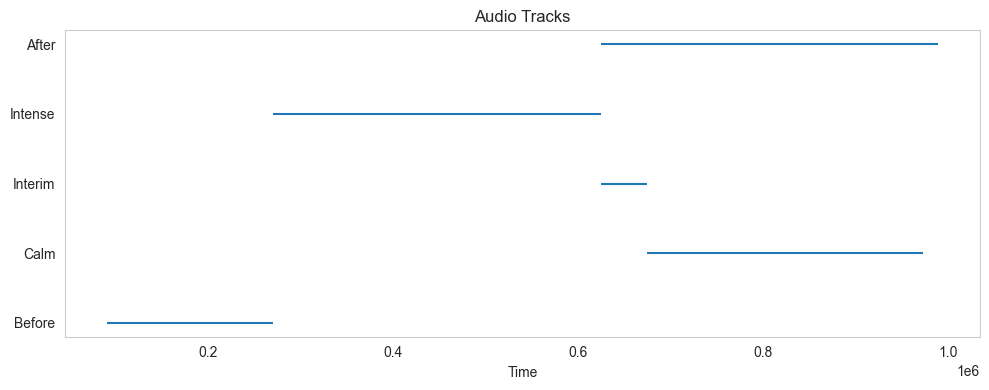

In [209]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

# Example Y positions for each class
class_labels = ['Before', 'Calm', 'Interim', 'Intense', 'After']
class_y = {
    'before': 0,
    'calm': 1,
    'interim': 2,
    'intense': 3,
    'after': 4
}

# Draw horizontal lines for each class range
ax.hlines(y=class_y['before'], xmin=before_range[0], xmax=before_range[-1], label='Before')
ax.hlines(y=class_y['calm'], xmin=calm_range[0], xmax=calm_range[-1], label='Calm')
ax.hlines(y=class_y['interim'], xmin=interim_range[0], xmax=interim_range[-1], label='Interim')
ax.hlines(y=class_y['intense'], xmin=intense_range[0], xmax=intense_range[-1], label='Intense')
ax.hlines(y=class_y['after'], xmin=after_range[0], xmax=after_range[-1], label='After')

ax.set_yticks(list(class_y.values()))
ax.set_yticklabels(class_labels)
ax.set_xlabel('Time')
ax.set_title('Audio Tracks')
ax.grid(False)
plt.tight_layout()
plt.show()


In [210]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

def plot_column(trimmed_data, column='VelocityX', unit='m'):

    # Set the figure size and style
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")

    # Plot the fixation duration over time
    plt.plot(trimmed_data['Timestamp'], trimmed_data[column],
            color='#3498db', linewidth=1.5, alpha=0.7)

    # Define color scheme for different audio segments
    colors = {
        'Before': '#D3D3D3',  # Light gray
        'Calm': '#90CAF9',    # Light blue
        'Interim': '#FFD54F', # Light amber
        'Intense': '#EF5350', # Light red
        'After': '#D3D3D3'    # Light gray
    }

    # Add colored background regions for each audio segment
    y_min, y_max = plt.ylim()
    plt.axvspan(before_audio_start['Timestamp'], before_audio_end['Timestamp'],
                alpha=0.2, color=colors['Before'], label='Before Audio')
    plt.axvspan(calm_audio_start['Timestamp'], calm_audio_end['Timestamp'],
                alpha=0.2, color=colors['Calm'], label='Calm Audio')
    plt.axvspan(interim_audio_start['Timestamp'], interim_audio_end['Timestamp'],
                alpha=0.2, color=colors['Interim'], label='Interim Audio')
    plt.axvspan(intense_audio_start['Timestamp'], intense_audio_end['Timestamp'],
                alpha=0.2, color=colors['Intense'], label='Intense Audio')
    plt.axvspan(intense_audio_end['Timestamp'], after_audio_end['Timestamp'],
                alpha=0.2, color=colors['After'], label='After Audio')

    # Add vertical lines at transition points
    plt.axvline(x=before_audio_start['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=calm_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=calm_audio_start['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=calm_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=interim_audio_start['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=interim_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=intense_audio_start['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=intense_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=after_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)

    # Add titles and labels
    plt.title(f'{column} During Different Audio Segments', fontsize=16, pad=20)
    plt.xlabel('Time (ms)', fontsize=12)
    plt.ylabel(f'{column} ({unit})', fontsize=12)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

    # Improve x-axis readability by converting to relative time
    relative_timestamps = []

    plt.xticks([t[1] for t in relative_timestamps],
            [f"{t[0]}\n{t[2]:.1f}s" for t in relative_timestamps],
            rotation=45)

    plt.tight_layout()

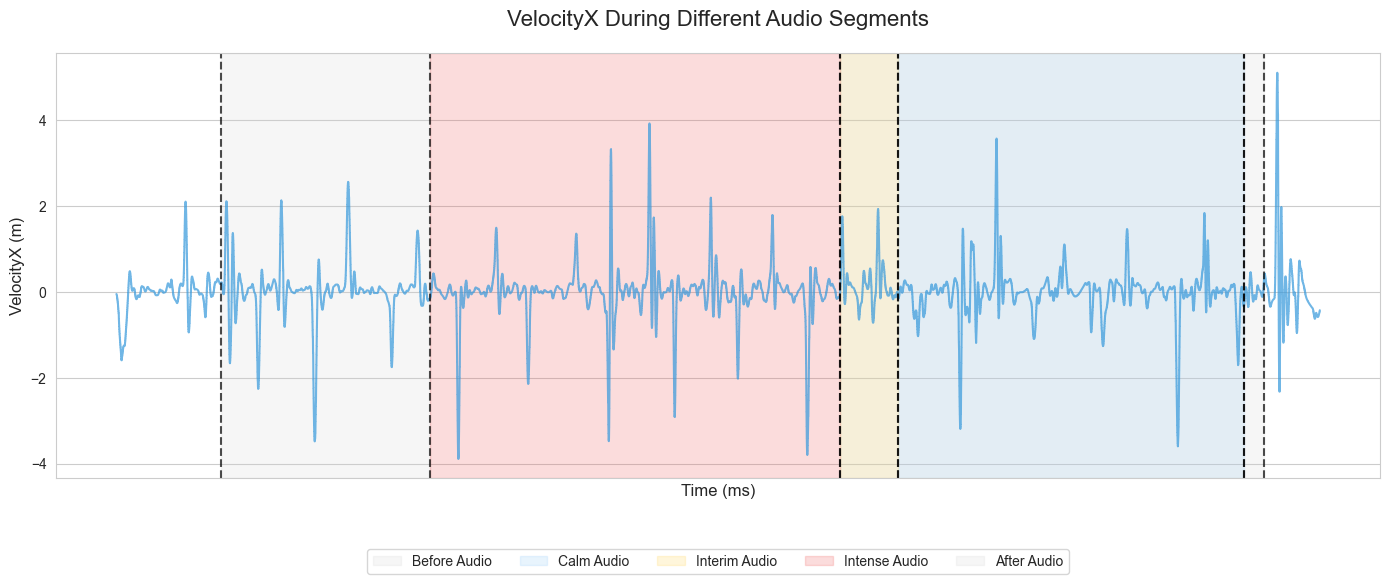

In [211]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

plot_column(trimmed_data)


In [212]:
eye_states = pd.read_csv('data/3d_eye_states_W1.csv', comment='#')


In [213]:
(1746542060713891492 - 1746542059989000000) / (10**6)

724.891492

In [214]:
timestamp_str = "06.05.2025,Time: 14:34:19.989"
# timestamp_str = "06.05.2025,Time: 13:28:59.307"
ts = pd.to_datetime(timestamp_str, format="%d.%m.%Y,Time: %H:%M:%S.%f")

# Get nanoseconds since epoch
nanoseconds = int(ts.value)  # .value gives nanoseconds as int

print(nanoseconds)

1746542059989000000


In [215]:
eye_states['timestamp [ns]'] = eye_states['timestamp [ns]'].apply(lambda x: (x - nanoseconds)/ (10**6))


In [216]:
eye_states['timestamp [ns]'] 

0         7.199025e+02
1         7.248915e+02
2         7.298915e+02
3         7.348915e+02
4         7.398915e+02
              ...     
207086    1.039393e+06
207087    1.039398e+06
207088    1.039403e+06
207089    1.039408e+06
207090    1.039413e+06
Name: timestamp [ns], Length: 207091, dtype: float64

In [217]:
eye_states.rename(columns={'timestamp [ns]': 'Timestamp'}, inplace=True)
eye_states.rename(columns={'pupil diameter left [mm]': 'ET_PupilLeft'}, inplace=True)
eye_states.rename(columns={'pupil diameter right [mm]': 'ET_PupilRight'}, inplace=True)

In [218]:
data['ET_PupilLeft'] = np.nan
data['ET_PupilRight'] = np.nan

In [219]:
subset = eye_states[['Timestamp', 'ET_PupilLeft','ET_PupilRight']]

# Append to df1
combined = pd.concat([data, subset], ignore_index=True)

# Sort by timestep
combined_sorted = combined.sort_values(by='Timestamp').reset_index(drop=True)

In [220]:
interpolated_data2 = combined_sorted.interpolate('pad')
trimmed_data2 = interpolated_data2[['Timestamp', 'Channel 13 (Raw)','Channel 9 (Raw)', 'MarkerName','MarkerDescription','MarkerType', 'DistanceToNextSpeedSign', 'DistanceToNextOverheadSign', 'VelocityX', 'DistanceToTargetPosition',
       'DistanceToTargetSpeed', 'CarSpeed', 'ET_PupilLeft', 'ET_PupilRight']]

C:\Users\JonathanKubik\AppData\Local\Temp\ipykernel_28568\2983910163.py:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data2 = combined_sorted.interpolate('pad')


In [221]:
interpolated_data2['ET_PupilRight_Mean'] = interpolated_data2['ET_PupilRight'].rolling(window=10000).mean()

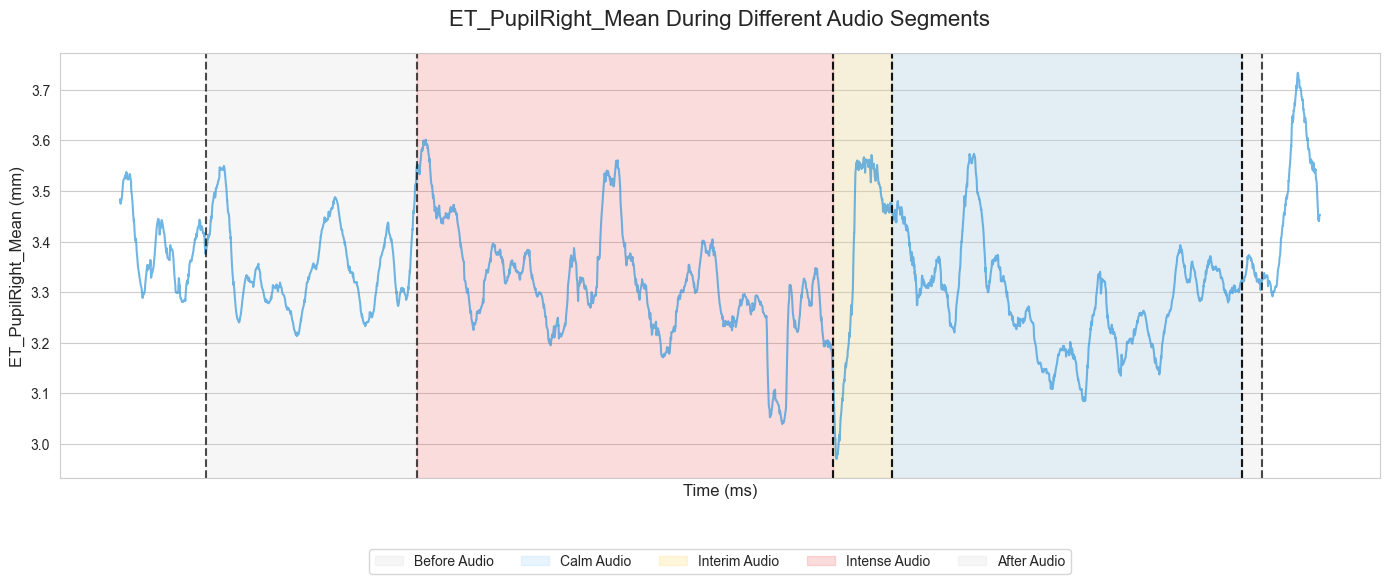

In [222]:
plot_column(interpolated_data2, 'ET_PupilRight_Mean', 'mm')